# Ant Trajectory Data Preprocessing

This notebook contains the code to take the direct output of the SLEAP tracking software (`.slp` files) and export it to individual trajectory segments with plenty of metadata attached.

The functions that are used here can be found in the `tracker/sleap_postprocess.py` file; see there for more information about how we extract data from a SLEAP-generated file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import h5py
from tqdm import tqdm

import pandas as pd
from dateutil import parser

# This is the only notebook that needs sleap installed; I would
# recommend having a separate python environment for sleap, use
# that to run this notebook, and then switch to another environment
# with your more typical packages (scipy, skimage, etc.) for the
# other notebooks
import sleap

# Our library in the tracker/ folder.
import sys
sys.path.append('../')

from tracker import pltsaveall, trackSleapFile, cleanMetadata

2026-02-17 09:02:57.517700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jack/miniconda3/envs/sleap/lib/python3.7/site-packages/cv2/../../lib64:/usr/share/pixelink/lib/
2026-02-17 09:02:57.517729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Quantify error in tracking

This requires the files from the trained model, as opposed to the rest of the notebook which uses the prediction files as input.

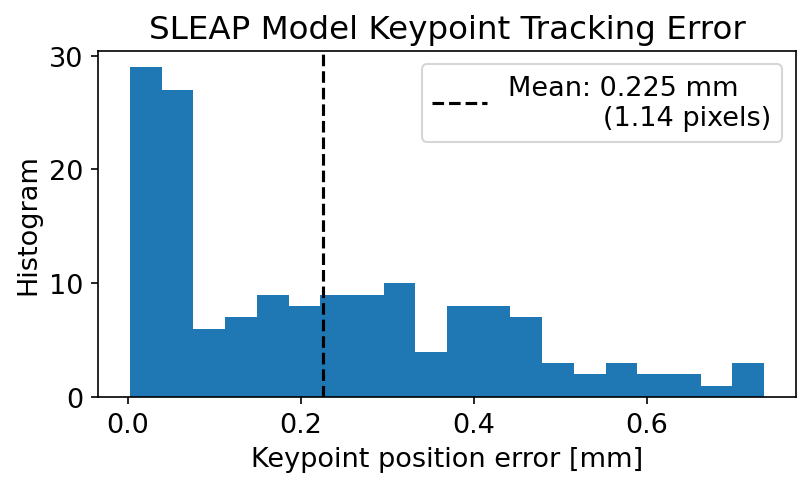

In [3]:
modelFolder = '/home/jack/Workspaces/data/ant_tracking/dataset_1/sleap_models/AntTrack.BottomView250828_135116.centered_instance/'

metrics = sleap.load_metrics(modelFolder, split="val")

mmPerPixel = 0.198

plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

plt.hist(metrics["dist.dists"].flatten() * mmPerPixel, bins=20)
plt.axvline(np.nanmean(metrics["dist.dists"]) * mmPerPixel, linestyle='--', c='black',
            label=f'Mean: {np.nanmean(metrics["dist.dists"]) * mmPerPixel:.3} mm\n           ({np.nanmean(metrics["dist.dists"]):.3} pixels)')

plt.xlabel("Keypoint position error [mm]")
plt.ylabel('Histogram')
plt.legend()
plt.title('SLEAP Model Keypoint Tracking Error')
#pltsaveall('00_TrackingError')
plt.show()

# Dataset 1

This data has gone through several iterations, hence why this is often referred to as "2024 Retracked" data. The original analysis of the 2024 data turned out to have many discretization artifacts due to inaccuracy in the SLEAP model, and I have also taken extra datasets (for example with a high speed camera, usually referred to as "2025 Data"). To avoid confusion, I have decided to just rename this as "Dataset 1"; this is the main data that is analyzed in the manuscript.

The raw videos can be found in the "datset_1/cropped_videos" folder, and the SLEAP models can be found in the "dataset_1/sleap_models" folder.

## Extract SLEAP data and metadata

In [2]:
dataFolder = '/home/jack/Workspaces/data/ant_tracking/dataset_1/cropped_tracks/'
extension = 'slp'

files = np.sort([f for f in os.listdir(dataFolder) if f[-len(extension):] == extension])

print(files)

['2024-05-08-H_cropped_tracked.slp' '2024-05-20-A_cropped_tracked.slp'
 '2024-05-20-B_cropped_tracked.slp' '2024-05-20-C_cropped_tracked.slp'
 '2024-05-20-D_cropped_tracked.slp' '2024-05-20-E_cropped_tracked.slp'
 '2024-05-20-G_cropped_tracked.slp' '2024-05-20-H_cropped_tracked.slp'
 '2024-05-29-A_cropped_tracked.slp' '2024-05-29-B_cropped_tracked.slp'
 '2024-05-29-C_cropped_tracked.slp' '2024-05-29-D_cropped_tracked.slp'
 '2024-05-29-E_cropped_tracked.slp' '2024-05-29-F_cropped_tracked.slp'
 '2024-05-29-G_cropped_tracked.slp' '2024-06-25-A_cropped_tracked.slp'
 '2024-06-25-B_cropped_tracked.slp' '2024-06-25-C_cropped_tracked.slp'
 '2024-06-25-D_cropped_tracked.slp' '2024-06-26-A_cropped_tracked.slp'
 '2024-06-26-B_cropped_tracked.slp' '2024-06-26-C_cropped_tracked.slp'
 '2024-06-26-D_cropped_tracked.slp' '2024-06-26-E_cropped_tracked.slp'
 '2024-07-01-1A_cropped_tracked.slp' '2024-07-01-1B_cropped_tracked.slp'
 '2024-07-01-1C_cropped_tracked.slp' '2024-07-01-1D_cropped_tracked.slp'
 '

In [3]:
# Extract the data for every available file

# The maximum number of consecutive frames that we allow to be interpolated
# if we are missing data.
interpolationLength = 30 # frames
# The minimum score that we still consider to be a valid tracked
# instance.
minScore = 0.4 # [0 - 1]
# The maximum distance the ant is allowed to move per frame,
# above which we are probably counting jitter.
maxDistance = 15 # pixels

trajectoryList = []
frameList = []
metadataList = []

# This usually takes like 20 minutes for the 100+ files
for i in tqdm(range(len(files))):
    trajectory, frame, metadata = trackSleapFile(os.path.join(dataFolder, files[i]),
                                                 interpolationLength, minScore, maxDistance)
    trajectoryList += trajectory
    frameList += frame
    
    for j in range(len(frame)):
        clean = cleanMetadata(metadata)
        clean["name"] = f'{clean["dataset"]}:{j}'
        metadataList += [clean]
        
# Now we remove any segments that have zero length
goodSegments = [i for i in range(len(trajectoryList)) if len(trajectoryList[i]) > 0]

trajectoryList = [trajectoryList[i] for i in goodSegments]
frameList = [frameList[i] for i in goodSegments]
metadataList = [metadataList[i] for i in goodSegments]

100%|█████████████████████████████████████████| 113/113 [21:00<00:00, 11.16s/it]


Found 1488 trajectory segments.


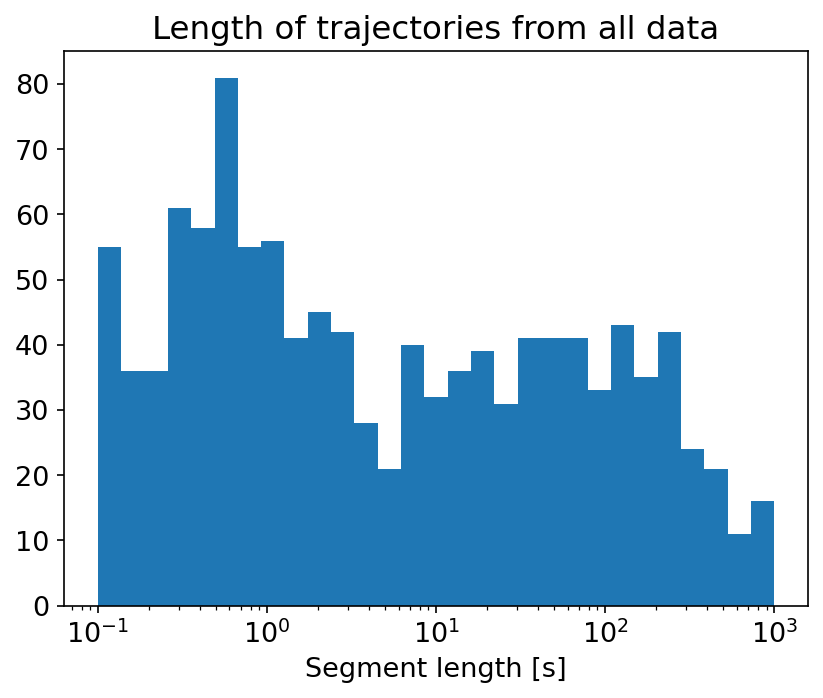

In [4]:
# Now we have a set of lists/arrays where each element of the
# list is a segment (a portion of a single video)
# As an example, lets plot the histogram of segment lengths
fps = 60
print(f'Found {len(trajectoryList)} trajectory segments.')

plt.hist([len(t)/fps for t in trajectoryList], bins=np.logspace(-1, 3, 30))
plt.xlabel('Segment length [s]')
#plt.yscale('log')
plt.xscale('log')
plt.title('Length of trajectories from all data')
plt.show()

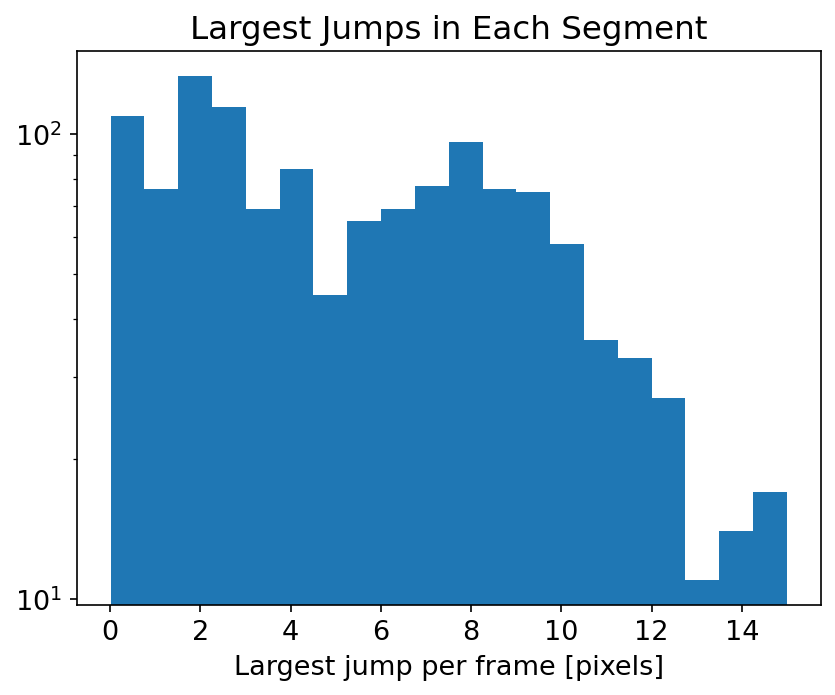

In [5]:
# Examine the biggest jump in each segment
jumpArr = np.array([np.max(np.sqrt(np.sum((t[1:] - t[:-1])**2, axis=-1))) for t in trajectoryList if len(t) > 1])

plt.hist(jumpArr, bins=20)
plt.yscale('log')
plt.xlabel('Largest jump per frame [pixels]')
plt.title('Largest Jumps in Each Segment')
plt.show()

Some of the trajectories shown below are outside of the container; this can happen because the video starts recording before the ant is actually placed in the container, so it is being tracked in the small entrance tube. The easiest way to do this is just to chop trajectories that go too far in the $x$ direction, past a cutoff point which is roughly $1100$ mm. We also have an issue with trajectories on the other side, though it's hard to see on this figure.

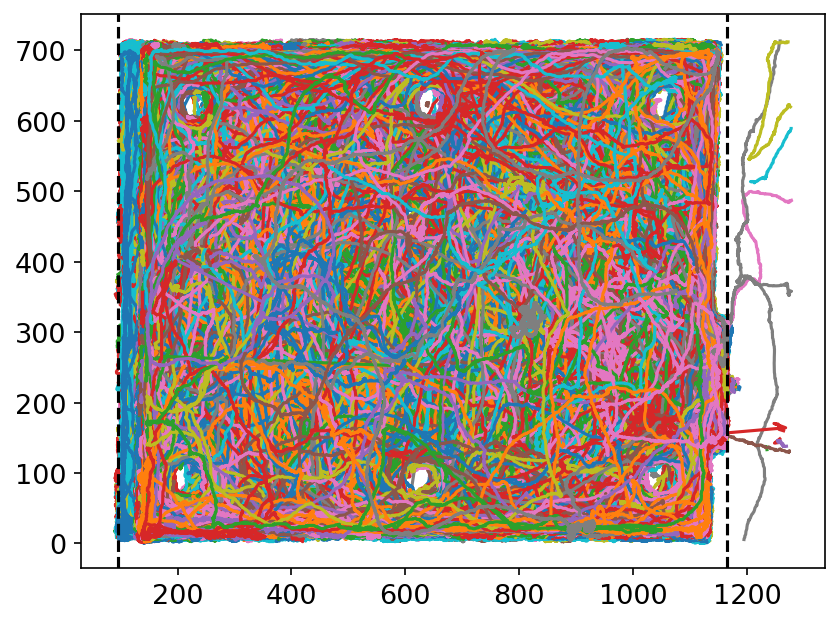

In [6]:
xRange = [95, 1165]

for i in range(len(trajectoryList)):
    plt.plot(*trajectoryList[i].T)

plt.axvline(xRange[0], linestyle='--', color='black')
plt.axvline(xRange[1], linestyle='--', color='black')

plt.show()

In [7]:
for i in tqdm(range(len(trajectoryList))):
    # Find all the indices where the trajectory is past the cutoff
    # For most segments this will be empty.
    badIndices = np.where((trajectoryList[i][:,0] < xRange[0]) | (trajectoryList[i][:,0] > xRange[1]))[0]
    goodIndices = [j for j in range(len(trajectoryList[i])) if j not in badIndices]
    
    # In this case, it's not a problem to just cut out the indices
    # that go beyond the cutoff. Since this is caused by the ant entering the
    # enclosure, it should never cause any weird skips in the middle
    # of a segment, just chopping the beginning of one.
    trajectoryList[i] = trajectoryList[i][goodIndices]
    frameList[i] = frameList[i][goodIndices]
    
# Now we remove any segments that got totally removed
goodSegments = [i for i in range(len(trajectoryList)) if len(trajectoryList[i]) > 0]

trajectoryList = [trajectoryList[i] for i in goodSegments]
frameList = [frameList[i] for i in goodSegments]
metadataList = [metadataList[i] for i in goodSegments]

100%|██████████████████████████████████████| 1488/1488 [00:11<00:00, 132.30it/s]


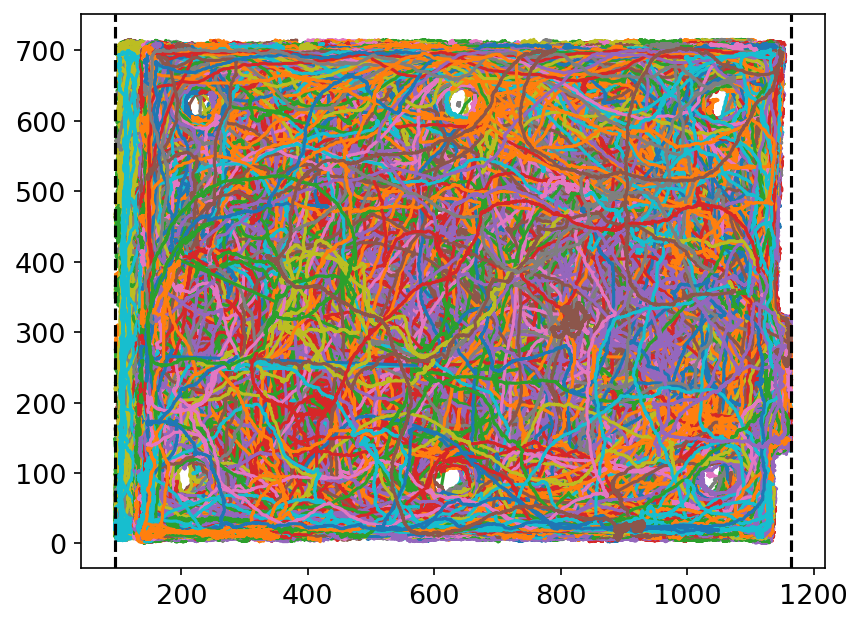

Found 1466 trajectory segments.


In [8]:
for i in range(len(trajectoryList)):
    plt.plot(*trajectoryList[i].T)

plt.axvline(xRange[0], linestyle='--', color='black')
plt.axvline(xRange[1], linestyle='--', color='black')
plt.show()

print(f'Found {len(trajectoryList)} trajectory segments.')

## Identify outlier trials

Given that we take lots of data, there are going to be some experiments trials that have issues, whether from the ant or from any other conditions. These are marked as "Outlier", but are still kept in the final dataset. This makes it easy to filter these trials out of any analysis, but makes it transparent which data is being excluded and why.

In [9]:
# Identify (manually) outlier trials
# This is a dictionary where the key should be the name
# of the trial that is an outlier, and the value should be
# a string explaining why this trial is an outlier.
outlierDict = {
                '2024-05-08-H': 'I have no information about this trial, it isn\'t included in the metadata table',
                '2024-05-20-A': 'Ant has a white pattern on gaster, indicating a different caste of ant',
                '2024-05-20-B': 'Same ant as 2024-05-20-A',
                '2024-05-20-C': 'Same ant as 2024-05-20-A',
                '2024-05-20-D': 'Same ant as 2024-05-20-A',
                '2024-05-20-F': 'Same ant as 2024-05-20-E',
                '2024-05-29-E': 'Ant has a white pattern on gaster, indicating a different caste of ant',
                '2024-07-11-C': 'Ant was missing a leg',
                '2024-06-25-D': 'Walks oddly, likely injured leg',
                '2024-06-26-A': 'Arena not completely dry after santizing',
                '2024-06-26-B': 'Arena not completely dry after santizing',
                '2024-06-26-C': 'Arena not completely dry after santizing',
                '2024-06-26-D': 'Arena not completely dry after santizing',
                '2024-06-26-E': 'Arena not completely dry after santizing',
                '2024-07-16-A': 'Ants were not interested in the food and had unusual behavior (?)',
                '2024-07-16-B': 'Ants were not interested in the food and had unusual behavior (?)',
                '2024-07-16-C': 'Ants were not interested in the food and had unusual behavior (?)',
                '2024-07-16-D': 'Ants were not interested in the food and had unusual behavior (?)',
                '2024-07-16-E': 'Ants were not interested in the food and had unusual behavior (?)',
                '2024-07-19-B': 'Was another ant in the enclosure that was injured, which is what the tracker focuses on',
              }

datasetNames = [m["dataset"] for m in metadataList]

outlierArr = [name in outlierDict for name in datasetNames]
outlierReasonArr = [outlierDict.get(k, '') for k in datasetNames]

print(f'Found {len(np.where(outlierArr)[0])} segments from outlier datasets.')

Found 190 segments from outlier datasets.


## Attach metadata about each trial

In the above section, we cleaned up the metadata from SLEAP; now we want to clean up and attach metadata about the experimental conditions for each trial.

In [10]:
# Load in the metadata about the experimental conditions (as opposed to the
# metadata about the tracking, which is what we already cleaned)
metadataFile = '/home/jack/Workspaces/data/ant_tracking/dataset_1/dataset_1_experimental_metadata_2026-01-01.csv'
cleanedMetadata = pd.read_csv(metadataFile)

columns = list(cleanedMetadata)

# Strip all of the strings in the name column just in case
# since we want to match them with filenames.
cleanedMetadata["name"] = cleanedMetadata["name"].apply(lambda x: str(x).strip())

# We need to adjust the naming, since I have switched
# an underscore to a dash in the new names:
# OLD: 2025-05-20_A
# NEW: 2025-05-20-A
cleanedMetadata["name"] = cleanedMetadata["name"].apply(lambda x: x.replace('_', '-'))

# Fill nan entries with an empty string
cleanedMetadata = cleanedMetadata.fillna('')

## Save the preprocessed data

Finally, we save all of the data and metadata we've just preprocessed and compiled.

In [11]:
# Now we save the compiled data into a single file
outputFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-02-01.h5'

# The following three variables are included in the metadata loaded in
# the previous cell, so we don't need to actually attach them.
# Pixel to mm conversion factor
# See lab notebook entry on March 14, 2025 for more info
# This is identified by taking still images from an ensemble of videos,
# and then measuring the length of each side of the arena in pixels. Since
# we know the true size of the arena in mm, we can easily calculate the conversion.
# Generally, we observe very consistent framing conditions, so a single
# value can be used across all trials.
# mmPerPixel = ...
# imageSize = ...
# fps = ...

# The keys to copy over from sleap
# We also copy over 'models' but we need to process that one a little so it's separate
sleapMetadataKeys = ['video_name', 'nodes', 'name', 'sleap_version', 'dataset']

missingMetadataDatasets = []
allDicts = []

with h5py.File(outputFile, 'w') as f:
    # Create a group for each segment we have.    
    for i in range(len(trajectoryList)):
        # Metadata about trial parameters
        try:
            trialMetadata = cleanedMetadata[cleanedMetadata["name"] == metadataList[i]["dataset"]].values[0]
            trialMetadata = dict(zip(columns, trialMetadata))
                        
            # Trash keys that are added by pandas
            removeKeys = [k for k in trialMetadata.keys() if 'Unnamed' in k]
            for k in removeKeys:
                del trialMetadata[k]

        except:
            # If we are missing metadata for a trial, we print it out. This could
            # be due to any number of reasons, but mostly it means that the data
            # comes from a preliminary trial before starting the "real" experiments.
            if metadataList[i]["dataset"] not in missingMetadataDatasets:
                print(f'No metadata found for trial {metadataList[i]["dataset"]}')
                if outlierArr[i]:
                    print('     ...but trial is an outlier.')
                missingMetadataDatasets.append(metadataList[i]["dataset"])
            continue

        # Not sure how exactly this can happen, but apparently
        # it does sometimes...
        if len(trajectoryList[i]) == 0:
            continue
            
        # Within the group, we have a dataset for the position of the ant,
        # and a dataset for the time arr of the tracking. It is important
        # to store this latter array, since we allow a single frame to be
        # skipped in a trajectory. Any gaps larger than one frame, are
        # split into multiple segments; note that this process is done in
        # SLEAP's tracking algorithm, not this file.
        dataset = f.create_dataset(f'{metadataList[i]["name"]}/frames', data=(frameList[i]).astype(np.float32))
        dataset = f.create_dataset(f'{metadataList[i]["name"]}/points', data=(trajectoryList[i]*trialMetadata["mm_per_pixel"]).astype(np.float32))

        # Attach metadata
        
        # Metadata about the experimental conditions
        dataset.attrs.update(trialMetadata)

        # Metadata about SLEAP tracking
        for k in sleapMetadataKeys:
            dataset.attrs[k] = metadataList[i][k]

        # Copy the model data, which needs to be formatted a bit
        models = metadataList[i]["models"]
        models = [str(os.path.basename(m)) for m in models]
        dataset.attrs['sleap_models'] = models
        
        dictionary = {}
        #dictionary["fps"] = fps        
        dictionary["outlier"] = outlierArr[i]
        dictionary["outlier_reason"] = outlierReasonArr[i]

        # Add the data about scaling
        dictionary["converted_to_mm"] = True
        
        # It's okay that these might be slightly off because of the 
        # small interpolation SLEAP does; they are mostly read-only.
        dictionary["total_time_seconds"] = (frameList[i][-1] - frameList[i][0]) / dataset.attrs["fps"]
        dictionary["total_time_minutes"] = (frameList[i][-1] - frameList[i][0]) / dataset.attrs["fps"] / 60
                
        dataset.attrs.update(dictionary)

        allDicts.append(dict(dataset.attrs))

No metadata found for trial 2024-05-08-H
     ...but trial is an outlier.
No metadata found for trial 2024-07-16-A
     ...but trial is an outlier.
No metadata found for trial 2024-07-16-B
     ...but trial is an outlier.
No metadata found for trial 2024-07-16-C
     ...but trial is an outlier.
No metadata found for trial 2024-07-16-D
     ...but trial is an outlier.
No metadata found for trial 2024-07-16-E
     ...but trial is an outlier.


# Dataset 2

This dataset is much smaller than the above one, but includes data taken at different frequencies and resolutions. In old documentation, this might be referred to as "2025 Data" because it was all taken in 2025.

The code below is almost exactly the same as above.

In [24]:
dataFolder = '/home/jack/Workspaces/data/ant_tracking/dataset_2/cropped_tracks/'
extension = 'slp'

files = np.sort([f for f in os.listdir(dataFolder) if f[-len(extension):] == extension])

print(files)

['2025-03-18-A_tracked.slp' '2025-03-18-B_tracked.slp'
 '2025-03-18-C_tracked.slp']


In [25]:
# Extract the data for every available file

# The maximum number of consecutive frames that we allow to be interpolated
# if we are missing data.
interpolationLength = 30 # frames
# The minimum score that we still consider to be a valid tracked
# instance.
minScore = 0.4 # [0 - 1]
# The maximum distance the ant is allowed to move per frame,
# above which we are probably counting jitter.
maxDistance = 15 # pixels

trajectoryList = []
frameList = []
metadataList = []

# This usually takes like 15 minutes for the 100+ files
for i in tqdm(range(len(files))):
    trajectory, frame, metadata = trackSleapFile(os.path.join(dataFolder, files[i]),
                                                 interpolationLength, minScore, maxDistance)
    trajectoryList += trajectory
    frameList += frame
    
    for j in range(len(frame)):
        clean = cleanMetadata(metadata)
        # For these trials, there is a mismatch in the internal name of
        # the dataset since it is 2025-03-18 for all of them where it should
        # be 2025-03-18_A or 2025-03-18_B etc.
        # To fix this, we just take the file name first part as the dataset.
        clean["dataset"] = files[i].split('_')[0]

        clean["name"] = f'{clean["dataset"]}:{j}'
        metadataList += [clean]
        
# Now we remove any segments that have zero length
goodSegments = [i for i in range(len(trajectoryList)) if len(trajectoryList[i]) > 0]

trajectoryList = [trajectoryList[i] for i in goodSegments]
frameList = [frameList[i] for i in goodSegments]
metadataList = [metadataList[i] for i in goodSegments]

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.60s/it]


10


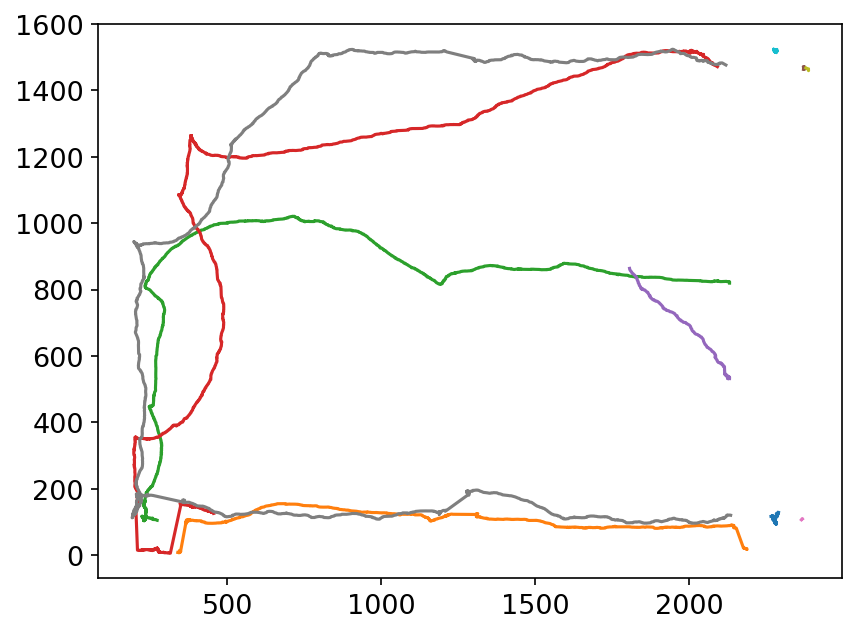

In [26]:
for i in range(len(trajectoryList)):
    plt.plot(*trajectoryList[i].T)
    
print(len(trajectoryList))
plt.show()

In [27]:
# Identify (manually) outlier trials
# This is a dictionary where the key should be the name
# of the trial that is an outlier, and the value should be
# a string explaining why this trial is an outlier.
outlierDict = {
              }

datasetNames = [m["dataset"] for m in metadataList]

outlierArr = [name in outlierDict for name in datasetNames]
outlierReasonArr = [outlierDict.get(k, '') for k in datasetNames]

print(f'Found {len(np.where(outlierArr)[0])} segments from outlier datasets.')

Found 0 segments from outlier datasets.


In [28]:
# Load in the metadata about the experimental conditions (as opposed to the
# metadata about the tracking, which is what we already cleaned)
metadataFile = '/home/jack/Workspaces/data/ant_tracking/dataset_2/dataset_2_experimental_metadata_2025-09-15.csv'
cleanedMetadata = pd.read_csv(metadataFile)

columns = list(cleanedMetadata)

# Strip all of the strings in the name column just in case
# since we want to match them with filenames.
cleanedMetadata["name"] = cleanedMetadata["name"].apply(lambda x: str(x).strip())

# We need to adjust the naming, since I have switched
# an underscore to a dash in the new names:
# OLD: 2025-05-20_A
# NEW: 2025-05-20-A
cleanedMetadata["name"] = cleanedMetadata["name"].apply(lambda x: x.replace('_', '-'))

# Fill nan entries with an empty string
cleanedMetadata = cleanedMetadata.fillna('')

In [30]:
# Now we save the compiled data into a single file
outputFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_2_2025-09-15.h5'

missingMetadataDatasets = []
allDicts = []

with h5py.File(outputFile, 'w') as f:
    # Create a group for each segment we have.    
    for i in range(len(trajectoryList)):
        # Metadata about trial parameters
        try:
            trialMetadata = cleanedMetadata[cleanedMetadata["name"] == metadataList[i]["dataset"]].values[0]
            trialMetadata = dict(zip(columns, trialMetadata))
                        
            # Trash keys that are added by pandas
            removeKeys = [k for k in trialMetadata.keys() if 'Unnamed' in k]
            for k in removeKeys:
                del trialMetadata[k]

        except:
            # If we are missing metadata for a trial, we print it out. This could
            # be due to any number of reasons, but mostly it means that the data
            # comes from a preliminary trial before starting the "real" experiments.
            if metadataList[i]["dataset"] not in missingMetadataDatasets:
                print(f'No metadata found for trial {metadataList[i]["dataset"]}')
                if outlierArr[i]:
                    print('     ...but trial is an outlier.')
                missingMetadataDatasets.append(metadataList[i]["dataset"])
            continue

        # Not sure how exactly this can happen, but apparently
        # it does sometimes...
        if len(trajectoryList[i]) == 0:
            continue
            
        # Within the group, we have a dataset for the position of the ant,
        # and a dataset for the time arr of the tracking. It is important
        # to store this latter array, since we allow a single frame to be
        # skipped in a trajectory. Any gaps larger than one frame, are
        # split into multiple segments; note that this process is done in
        # SLEAP's tracking algorithm, not this file.
        dataset = f.create_dataset(f'{metadataList[i]["name"]}/frames', data=(frameList[i]).astype(np.float32))
        dataset = f.create_dataset(f'{metadataList[i]["name"]}/points', data=(trajectoryList[i]*trialMetadata["mmPerPixel"]).astype(np.float32))

        # Attach metadata
        dictionary = {}
        dictionary["outlier"] = outlierArr[i]
        dictionary["outlier_reason"] = outlierReasonArr[i]

        # Add the data about scaling
        dictionary["convertedToMM"] = True
        # It's okay that these might be slightly off because of the 
        # small interpolation SLEAP does; they are mostly read-only.
        dictionary["totalTimeSeconds"] = (frameList[i][-1] - frameList[i][0]) / trialMetadata["fps"]
        dictionary["totalTimeMinutes"] = (frameList[i][-1] - frameList[i][0]) / trialMetadata["fps"] / 60
        
        dataset.attrs.update(dictionary)
        # Metadata about SLEAP tracking
        dataset.attrs.update(metadataList[i])
        # Metadata about the experimental conditions
        dataset.attrs.update(trialMetadata)
        
        allDicts.append(dict(dataset.attrs))